In [3]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gzip 

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from collections import Counter
from IPython.display import clear_output

# Deep Average Network для определения сентимента 

The task description is in Russian, but comments to the code are in English. The task is to build an MLP model that would categorize sentiments of tweets (negative, positive, or neutral).

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

In [4]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    """
    Function to load pre-trained embeddings
    """
    
    vocab = dict()
    embeddings = list()

    with gzip.open(file_path,'rt', encoding="utf8") as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # instead of using all 1 000 000 words from the file, let's restrit this number
        max_words = vocab_size if max_words <= 0 else max_words

        # adding PAD token to our embedding matrix and vocab
        vocab[pad_token] = 0
        pad_emb = np.zeros(embedding_dim)

        embeddings.append(pad_emb)

        # adding UNK token to our embedding matrix and vocab
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    assert(len(vocab) == embeddings.shape[0])
    
    return vocab, embeddings

In [5]:
# Load embeddings file
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

# Alternatively
# from google.colab import drive
# drive.mount('/content/drive')
# %cd ../content/drive/MyDrive/

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
vocab, embeddings = load_embeddings('cc.en.300.vec.gz', max_words=100_000)

Reading embeddings file:   0%|          | 0/100000 [00:00<?, ?it/s]

## Loading the data
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [7]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [8]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

In [16]:
class Tokenizer:
    
    """
    We will use it as collate function
    """
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer
        
        self.token2index = token2index
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        Splitting text string into tokens
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        Converting tokens to indicies
        """
        idxs = []
        for token in tokenized_text:
            if token not in self.token2index:
                idxs.append(self.unk_index)
            else:
                idxs.append(self.token2index[token])
        return idxs
        
    def padding(self, tokens_indices):
        """
        Adding PAD tokens till lenght is self.max_length
        """
        padded = []

        for idx in tokens_indices:
          if len(padded)==self.max_length:
                break
          elif idx!=1:
              padded.append(idx)
          elif len(padded)==0:
            padded.append(idx)
          else:
              if padded[-1]!=1:
                  padded.append(idx)
        while len(padded)<self.max_length:
          padded.append(self.pad_index)
        return padded
    
    def __call__(self, text):
        """
        Converting text string into tensor with token indicies (self.max_length)
        """
        return torch.tensor(self.padding(self.indexing(self.tokenize(text))))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            labels.append(sample['label'])
            tokenized_texts.append(self(sample['text']))
            
        tokenized_texts = torch.stack(tokenized_texts)
        labels = torch.Tensor(labels)
        
        return tokenized_texts, labels

In [17]:
# Defining the threshold for the text lenght

lengths = [len(ToktokTokenizer().tokenize(sample)) for sample in tqdm(train_dataset["text"])]
np.percentile(lengths, 94)

  0%|          | 0/45615 [00:00<?, ?it/s]

32.0

In [18]:
wordlim = 32

collate_fn = Tokenizer(ToktokTokenizer(), vocab, 'PAD', 'UNK', wordlim).collate

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [19]:
for x,y in train_loader:
    break

In [20]:
# Sanity check
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Deep Average Network

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику F1 weighted
Почему я выбрал эту метрику:  
Как можно видеть в результате кода ниже, количество данных сильно разнится для разных классов. Т.к. наша модель может научиться предсказывать одни классы лучше других, я посчитал необходимым использовать взвешенную метрику, ведь в таком случае не будет перевеса в сторону классов с большим количеством данных.

In [21]:
# Checking for the class imbalance in the training set

train_classes = [data['label'] for data in train_dataset]
Counter(train_classes)

Counter({2: 17849, 1: 20673, 0: 7093})

In [22]:
# Checking for the class imbalance in the validation set

val_classes = [data['label'] for data in valid_dataset]
Counter(val_classes)

Counter({1: 869, 2: 819, 0: 312})

In [23]:
# Checking for the class imbalance in the test set

test_classes = [data['label'] for data in test_dataset]
Counter(test_classes)

Counter({1: 5937, 2: 2375, 0: 3972})

In [24]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, actv, embs, hidden_unit_nums, output_feature_num, drop):
        
        super(DeepAverageNetwork, self).__init__()
        
        self.emb = torch.nn.Embedding.from_pretrained(torch.Tensor(embs))
        
        self.mlp = nn.Sequential() # all mlp-layers will be added here
        in_num = self.emb.embedding_dim # first layer inputs
        
        for i in range(len(hidden_unit_nums)): # layers will be added in similar blocks
          out_num = hidden_unit_nums[i] # outputs taken from the corresponding list
          layer = nn.Linear(in_num, out_num) # linear layer
          in_num = out_num # next layer inputs
          self.mlp.add_module('Linear_%d'%i, layer) # adding to the sequence

          batchnorm = nn.BatchNorm1d(num_features=out_num) # BatchNorm
          self.mlp.add_module('Batchnorm_%d'%i, batchnorm) # adding to the sequence

          actv_layer = eval('nn.%s'%actv) # activation function
          self.mlp.add_module('Activation_%d'%i, actv_layer) # adding to the sequence

          dropout = nn.Dropout(p=drop[i]) # Dropout
          self.mlp.add_module('Dropout_%d'%i, dropout) # adding to the sequence

        out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # adding to the sequence

    def forward(self, x):
        x = self.emb(x)
        x_avg = x.nanmean(1)
        logits = self.mlp(x_avg)
        return logits

In [25]:
# Function for weights initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

hidden_units = [375, 400, 500, 600] # numbers of neurons in sequential layers
dropouts = [0.2, 0.25, 0.4, 0.5] # Dropout value in those layers

model = DeepAverageNetwork('ReLU()', embeddings, hidden_units, 3, dropouts)
model.apply(init_weights)
model.to(device)

DeepAverageNetwork(
  (emb): Embedding(100000, 300)
  (mlp): Sequential(
    (Linear_0): Linear(in_features=300, out_features=375, bias=True)
    (Batchnorm_0): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_0): ReLU()
    (Dropout_0): Dropout(p=0.2, inplace=False)
    (Linear_1): Linear(in_features=375, out_features=400, bias=True)
    (Batchnorm_1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_1): ReLU()
    (Dropout_1): Dropout(p=0.25, inplace=False)
    (Linear_2): Linear(in_features=400, out_features=500, bias=True)
    (Batchnorm_2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_2): ReLU()
    (Dropout_2): Dropout(p=0.4, inplace=False)
    (Linear_3): Linear(in_features=500, out_features=600, bias=True)
    (Batchnorm_3): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_3): ReLU()
 

## Loss function and optimizer

In [27]:
tokenizer = Tokenizer(ToktokTokenizer(), vocab, 'PAD', 'UNK', wordlim)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.7,
                                                       patience=1,
                                                       verbose=True)

## Training loop

In [28]:
# Function for plotting
def plot_losses(train_losses, test_losses, train_metrics, test_metrics):
    
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(test_metrics) + 1), test_metrics, label='test')
    axs[1].set_ylabel('F1 weighted')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

    
# Training for one epoch
def train_one_epoch(model, train_loader, tokenizer, criterion, optimizer, epoch, num_epochs, device="cuda:0"):
    
    model.train()
    running_loss, running_metric = 0.0, 0.0
    
    for texts, labels in tqdm(train_loader, desc=f'Training {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()

        texts = texts.to(device)
        labels = labels.to(device)
        
        logits = model(texts)
        loss = criterion(logits, labels.long())
        loss.mean().backward() 
        optimizer.step() 

        running_loss += loss.sum() # summing the losses (average is computed later)
        running_metric += f1_score(labels.cpu(), logits.argmax(dim=-1).cpu(), average='weighted') # summing the metric
    return running_loss, running_metric

# Prediction
def predict(model, val_loader, criterion, device="cuda:0"):
    
    model.eval()
    losses, predicted_classes, true_classes = [], [], []
    
    for texts, labels in tqdm(val_loader, desc=f'Testing'):
        texts = texts.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(texts)
            loss = criterion(logits, labels.long())
        
        losses += [loss]
        predicted_classes += [logits.argmax(dim=-1)] 
        true_classes += [labels]

    return torch.cat(losses), torch.cat(predicted_classes).cpu(), torch.cat(true_classes).cpu()


# Training loop
def train(model, train_loader, val_loader, tokenizer, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    
    train_losses, test_losses = [], []
    train_metrics, test_metrics = [], []
    
    for epoch in range(n_epochs):
        # Training
        epoch_loss, epoch_metric = train_one_epoch(model,
                                                   train_loader,
                                                   tokenizer,
                                                   criterion,
                                                   optimizer,
                                                   epoch,
                                                   n_epochs,
                                                   device)
        train_losses += [epoch_loss / len(train_loader.dataset)] # average loss in the train set
        # average metric in the train set
        train_metrics += [epoch_metric * batch_size / len(train_loader.dataset)] 

        # Testing after each epoch
        all_losses, predicted_labels, true_labels = predict(model,
                                                            val_loader,
                                                            criterion,
                                                            device)
        test_losses += [torch.mean(all_losses).item()] # average loss in the validation set
        # average metric in the validation set
        test_metrics += [f1_score(true_labels, predicted_labels, average='weighted')]
        
        plot_losses(train_losses, test_losses, train_metrics, test_metrics) # plotting after each epoch

        if scheduler:
            # Scheduler depends on valedation set loss
            scheduler.step(test_losses[-1])

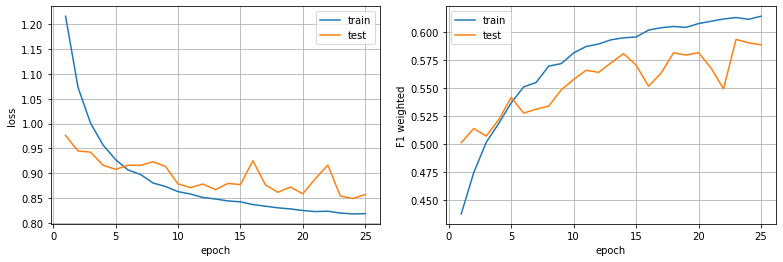

In [29]:
NUM_EPOCHS = 25  # Number of epochs

train(model, train_loader, valid_loader, tokenizer, criterion, optimizer, device, NUM_EPOCHS, scheduler)

In [31]:
all_losses, predicted_labels, true_labels = predict(model, test_loader, criterion, device)
assert len(predicted_labels) == len(test_dataset)
metric = f1_score(true_labels, predicted_labels, average='weighted')
metric

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

0.5840653626295877

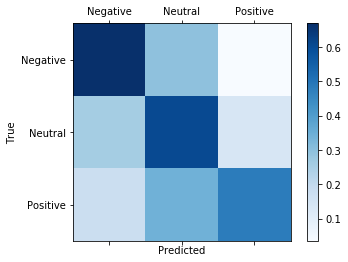

              precision    recall  f1-score   support

    Negative       0.67      0.42      0.52      3972
     Neutral       0.61      0.71      0.66      5937
    Positive       0.48      0.56      0.52      2375

    accuracy                           0.59     12284
   macro avg       0.58      0.57      0.56     12284
weighted avg       0.60      0.59      0.58     12284



In [33]:
# confusion matrix and classification report
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(predicted_labels, true_labels, normalize='true'), cmap=plt.cm.Blues)
fig.colorbar(cax)

labels = ['', 'Negative', 'Neutral', 'Positive']
ax.set_xticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_yticklabels(labels)
ax.set_ylabel('True')

plt.show()

print(classification_report(true_labels, predicted_labels, target_names=labels[1:]))

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Пробовал разные гиперпараметры для данной модели, но выше 0.60 F1 на тестовом сете не поднимается.  
Вероятно, качество улучшилось бы, если бы паддинги не учитывались при подсчете среднего. Я пытался это сделать, заменив нули в эмбеддинге PAD-токенов на NaN'ы (вторая ячейка кода, строка 25), но тогда перестает корректно работать backprop (функция mean() распространяет NaN в градиентах, а с функцией nanmean() модель почему-то перестает обучается - лосс не падает).  
Весьма вероятно, также, что выбор другого словаря для эмбеддингов хорошо отразился бы на качестве модели, но времени попробовать разные уже не было.  